In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math # Para calcular RMSE
from datetime import date
import time # Para medir tiempo de entrenamiento
import copy # Para guardar el mejor modelo en Early Stopping
import random # Para búsqueda de hiperparámetros

# Configuración del dispositivo (GPU si está disponible, si no CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\jacob\anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using device: cuda


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


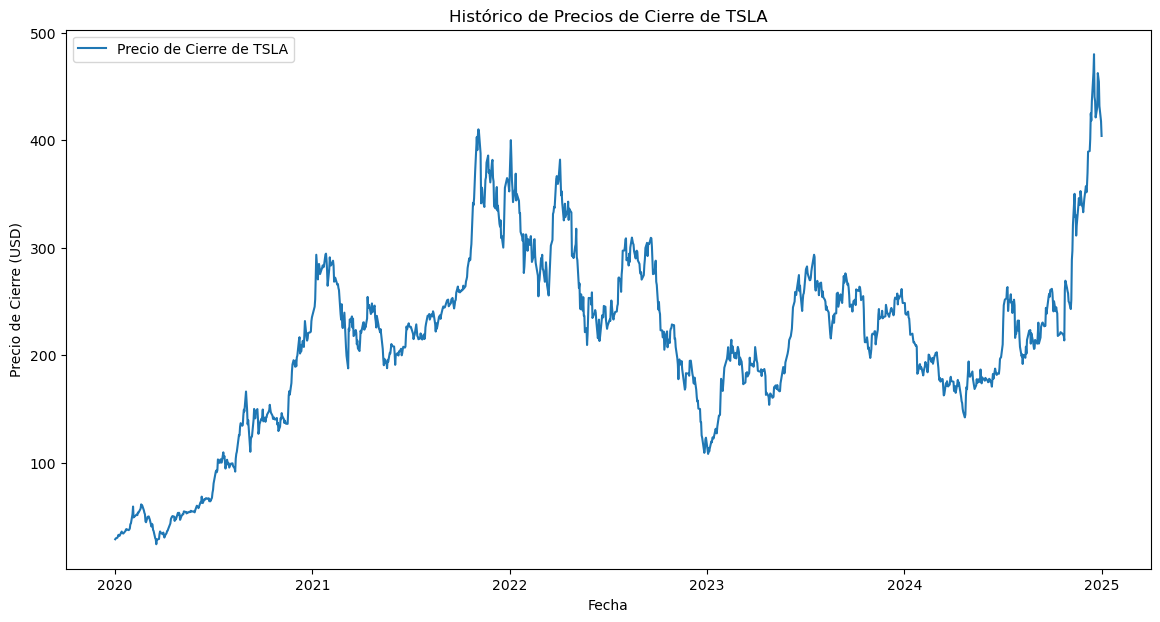

In [2]:
# --- Parámetros ---
ticker = 'TSLA'
start_date = '2020-01-01'
end_date = '2025-01-01'

# --- Descarga de Datos ---
data = yf.download(ticker, start=start_date, end=end_date)

# --- Visualización del Precio de Cierre ---
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label=f'Precio de Cierre de TSLA')
plt.title(f'Histórico de Precios de Cierre de TSLA')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.show()

In [3]:
# --- Preprocesamiento, División y Escalado  ---

target_column = 'Close'
price_data = data[[target_column]].copy() # Usar solo la columna target como DataFrame

# --- División Train/Validation/Test (70/15/15) ANTES de escalar ---
data_len = len(price_data)
train_split_idx = int(data_len * 0.70)
val_split_idx = int(data_len * 0.85) # 70% + 15% = 85%

train_data = price_data[:train_split_idx]
val_data = price_data[train_split_idx:val_split_idx]
test_data = price_data[val_split_idx:]

print(f"Tamaños -> Entrenamiento: {len(train_data)}, Validación: {len(val_data)}, Prueba: {len(test_data)}")

# --- Escalado (Fit SOLO en Train, Transform en todos) ---
scaler = MinMaxScaler(feature_range=(0, 1))
# Ajustar el scaler SOLO con los datos de entrenamiento
scaler.fit(train_data)

# Transformar los tres conjuntos
scaled_train_data_np = scaler.transform(train_data)
scaled_val_data_np = scaler.transform(val_data)
scaled_test_data_np = scaler.transform(test_data)

# Guardar el dataset escalado completo (para la predicción futura iterativa después)
scaled_data_np_full = np.concatenate((scaled_train_data_np, scaled_val_data_np, scaled_test_data_np), axis=0)

print(f"\nForma de los datos escalados (Numpy):")
print(f"  Train: {scaled_train_data_np.shape}")
print(f"  Validation: {scaled_val_data_np.shape}")
print(f"  Test: {scaled_test_data_np.shape}")

Tamaños -> Entrenamiento: 880, Validación: 189, Prueba: 189

Forma de los datos escalados (Numpy):
  Train: (880, 1)
  Validation: (189, 1)
  Test: (189, 1)


In [4]:
# --- Creación de Secuencias Temporales ---

# Función para crear secuencias
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Parámetro de Ventana Temporal 
window_size = 20

# 1. Crear secuencias sobre TODOS los datos escalados
print(f"Creando secuencias sobre datos escalados completos (Shape: {scaled_data_np_full.shape})")
X_full_np, y_full_np = create_sequences(scaled_data_np_full, window_size)
print(f"Forma de secuencias completas (Numpy): X={X_full_np.shape}, y={y_full_np.shape}")

# 2. Determinar índices para dividir las SECUENCIAS
train_seq_end_idx = len(scaled_train_data_np) - window_size
val_seq_end_idx = len(scaled_train_data_np) + len(scaled_val_data_np) - window_size

print(f"\nÍndices de división para secuencias:")
print(f"  Fin Entrenamiento (índice y): {train_seq_end_idx}")
print(f"  Fin Validación (índice y): {val_seq_end_idx}")

# 3. Dividir los arrays de secuencias X_full_np y y_full_np
X_train_np = X_full_np[:train_seq_end_idx]
y_train_np = y_full_np[:train_seq_end_idx]

X_val_np = X_full_np[train_seq_end_idx:val_seq_end_idx]
y_val_np = y_full_np[train_seq_end_idx:val_seq_end_idx]

X_test_np = X_full_np[val_seq_end_idx:]
y_test_np = y_full_np[val_seq_end_idx:]

print(f"\nForma de secuencias divididas (Numpy):")
print(f"  Train:      X={X_train_np.shape}, y={y_train_np.shape}")
print(f"  Validation: X={X_val_np.shape}, y={y_val_np.shape}")
print(f"  Test:       X={X_test_np.shape}, y={y_test_np.shape}")

Creando secuencias sobre datos escalados completos (Shape: (1258, 1))
Forma de secuencias completas (Numpy): X=(1238, 20), y=(1238,)

Índices de división para secuencias:
  Fin Entrenamiento (índice y): 860
  Fin Validación (índice y): 1049

Forma de secuencias divididas (Numpy):
  Train:      X=(860, 20), y=(860,)
  Validation: X=(189, 20), y=(189,)
  Test:       X=(189, 20), y=(189,)


In [5]:
# --- Convertir a Tensores y Obtener Fechas ---

# Convertir los arrays NumPy divididos a Tensores de PyTorch
X_train = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val_np, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val_np, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(-1)

print(f"\nForma Tensores:")
print(f"  Train:      X={X_train.shape}, y={y_train.shape}")
print(f"  Validation: X={X_val.shape}, y={y_val.shape}")
print(f"  Test:       X={X_test.shape}, y={y_test.shape}")

# --- Obtener las fechas correspondientes a los TARGETS de cada conjunto ---
val_start_idx_in_original = train_split_idx
val_end_idx_in_original = val_split_idx
val_dates = data.index[val_start_idx_in_original:val_end_idx_in_original]

test_start_idx_in_original = val_split_idx
test_dates = data.index[test_start_idx_in_original:]

print(f"\nLongitud de fechas vs targets (deberían coincidir):")
print(f"  Val:  Fechas={len(val_dates)}, Targets={len(y_val)}")
print(f"  Test: Fechas={len(test_dates)}, Targets={len(y_test)}")

# Ajustar longitud de fechas si es necesario (por creación de secuencias)
if len(val_dates) > len(y_val):
    val_dates = val_dates[:len(y_val)]
if len(test_dates) > len(y_test):
    test_dates = test_dates[:len(y_test)]


Forma Tensores:
  Train:      X=torch.Size([860, 20, 1]), y=torch.Size([860, 1])
  Validation: X=torch.Size([189, 20, 1]), y=torch.Size([189, 1])
  Test:       X=torch.Size([189, 20, 1]), y=torch.Size([189, 1])

Longitud de fechas vs targets (deberían coincidir):
  Val:  Fechas=189, Targets=189
  Test: Fechas=189, Targets=189


In [6]:
# --- Datasets y DataLoaders ---
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Parámetro Batch Size
batch_size = 32

# Crear los tres Datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val) # Dataset de Validación
test_dataset = TimeSeriesDataset(X_test, y_test)  # Dataset de Prueba

# Crear los tres DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# --- Definición del Modelo LSTM ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, num_layers=1, output_size=1, dropout_prob=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers,
                            batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        out = self.dropout(lstm_out)
        predictions = self.linear(out[:, -1, :])
        return predictions

# Parámetros del Modelo
lstm_units = 128
num_lstm_layers = 2
dropout_rate = 0.1

# Instanciar el modelo
model = LSTMModel(input_size=1,
                  hidden_layer_size=lstm_units,
                  num_layers=num_lstm_layers,
                  output_size=1,
                  dropout_prob=dropout_rate).to(device)

print("\nModelo LSTM:")
print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total de parámetros: {total_params}")


Modelo LSTM:
LSTMModel(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Total de parámetros: 199297


In [8]:
# --- Entrenamiento Simple  ---

# --- Hiperparámetros de Entrenamiento ---
learning_rate = 0.01
epochs = 100
patience = 10

# --- Función de Pérdida y Optimizador ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Variables para seguimiento y Early Stopping ---
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
train_losses = []
val_losses = []

print("\nIniciando Entrenamiento...")
start_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    batch_count = 0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_count += 1

    avg_train_loss = running_loss / batch_count if batch_count > 0 else 0
    train_losses.append(avg_train_loss)

    # --- Validación ---
    model.eval()
    running_val_loss = 0.0
    val_batch_count = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()
            val_batch_count += 1

    avg_val_loss = running_val_loss / val_batch_count if val_batch_count > 0 else float('inf')
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # --- Early Stopping ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'\nEarly stopping activado después de {epoch+1} epochs.')
        break

end_time = time.time()
print(f"\nEntrenamiento completado en {end_time - start_time:.2f} segundos.")

# Cargar el mejor modelo encontrado
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Modelo final cargado con los mejores pesos de validación.")
else:
     print("Advertencia: No se guardó ningún modelo.")


Iniciando Entrenamiento...
Epoch [1/100], Train Loss: 0.048543, Val Loss: 0.003323
Epoch [2/100], Train Loss: 0.004327, Val Loss: 0.000781
Epoch [3/100], Train Loss: 0.001913, Val Loss: 0.000777
Epoch [4/100], Train Loss: 0.001782, Val Loss: 0.000857
Epoch [5/100], Train Loss: 0.001746, Val Loss: 0.001678
Epoch [6/100], Train Loss: 0.001306, Val Loss: 0.000598
Epoch [7/100], Train Loss: 0.001436, Val Loss: 0.001354
Epoch [8/100], Train Loss: 0.001412, Val Loss: 0.000502
Epoch [9/100], Train Loss: 0.001074, Val Loss: 0.000575
Epoch [10/100], Train Loss: 0.001273, Val Loss: 0.000784
Epoch [11/100], Train Loss: 0.001499, Val Loss: 0.000585
Epoch [12/100], Train Loss: 0.001480, Val Loss: 0.000523
Epoch [13/100], Train Loss: 0.001162, Val Loss: 0.000641
Epoch [14/100], Train Loss: 0.001076, Val Loss: 0.000427
Epoch [15/100], Train Loss: 0.000923, Val Loss: 0.000399
Epoch [16/100], Train Loss: 0.000985, Val Loss: 0.000470
Epoch [17/100], Train Loss: 0.001059, Val Loss: 0.000635
Epoch [18/10

In [9]:
# --- Evaluación con el Test Set ---

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

predicted_scaled_np = np.concatenate(all_preds, axis=0)
actual_scaled_np = np.concatenate(all_targets, axis=0)

# --- Invertir la Normalización ---
predicted_prices = scaler.inverse_transform(predicted_scaled_np)
actual_prices = scaler.inverse_transform(actual_scaled_np)

# --- Calcular Métricas de Evaluación ---
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = math.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)

print("\n--- Evaluación del Modelo en el Conjunto de Prueba ---")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

# Guardar métricas
results_pytorch_simple = {
    'MSE': mse, 'RMSE': rmse, 'MAE': mae,
    'Config': {
        'window_size': window_size, 'lstm_units': lstm_units, 'num_layers': num_lstm_layers,
        'dropout_rate': dropout_rate, 'learning_rate': learning_rate,
        'epochs_run': len(train_losses), 'batch_size': batch_size
    }
}
print("\nConfiguración y Resultados:")
print(results_pytorch_simple)


--- Evaluación del Modelo en el Conjunto de Prueba ---
Error Cuadrático Medio (MSE): 141.6455
Raíz del Error Cuadrático Medio (RMSE): 11.9015
Error Absoluto Medio (MAE): 7.9876

Configuración y Resultados:
{'MSE': 141.64548, 'RMSE': 11.901490549293474, 'MAE': 7.9876223, 'Config': {'window_size': 20, 'lstm_units': 128, 'num_layers': 2, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'epochs_run': 52, 'batch_size': 32}}


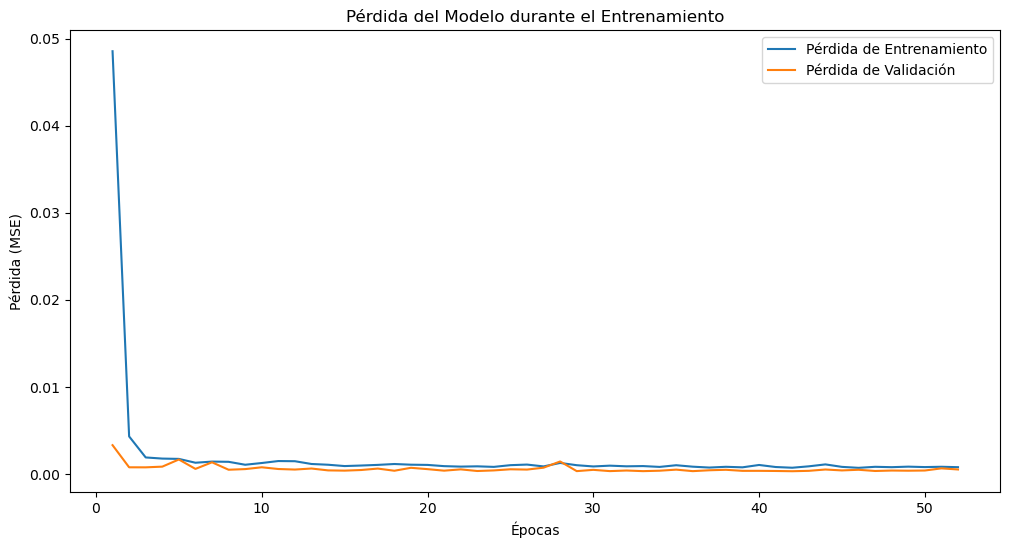

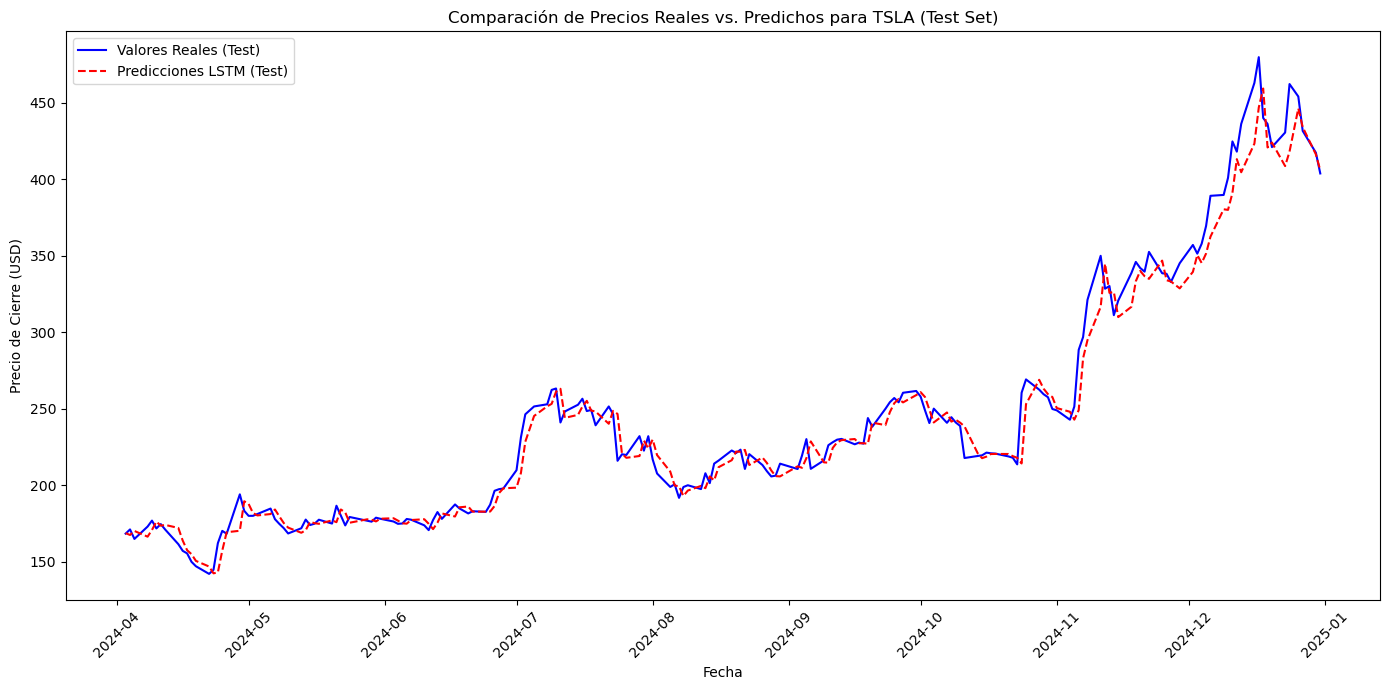

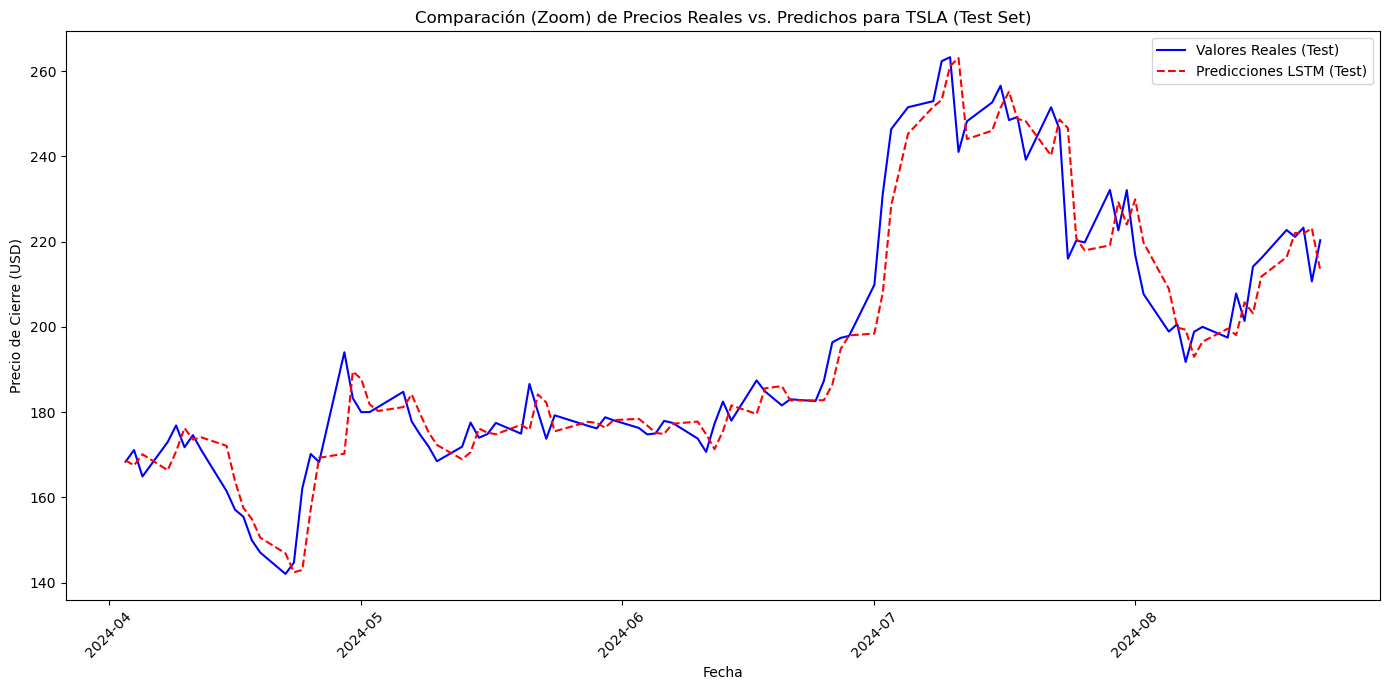

In [10]:
# --- Gráfica de la Pérdida ---
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Pérdida de Entrenamiento')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Pérdida de Validación')
plt.title('Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.show()

# --- Comparación Gráfica (Test Set) ---
plt.figure(figsize=(14, 7))
plt.plot(test_dates, actual_prices.flatten(), label='Valores Reales (Test)', color='blue', linestyle='-') # .flatten() para asegurar 1D
plt.plot(test_dates, predicted_prices.flatten(), label='Predicciones LSTM (Test)', color='red', linestyle='--') # .flatten()
plt.title(f'Comparación de Precios Reales vs. Predichos para {ticker} (Test Set)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Zoom (Test Set) ---
zoom_end = min(100, len(test_dates))
plt.figure(figsize=(14, 7))
plt.plot(test_dates[:zoom_end], actual_prices[:zoom_end].flatten(), label='Valores Reales (Test)', color='blue', linestyle='-') # .flatten()
plt.plot(test_dates[:zoom_end], predicted_prices[:zoom_end].flatten(), label='Predicciones LSTM (Test)', color='red', linestyle='--') # .flatten()
plt.title(f'Comparación (Zoom) de Precios Reales vs. Predichos para {ticker} (Test Set)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Iniciando predicción iterativa para 50 pasos con noise_level=0.02...
Predicción iterativa con ruido completada.


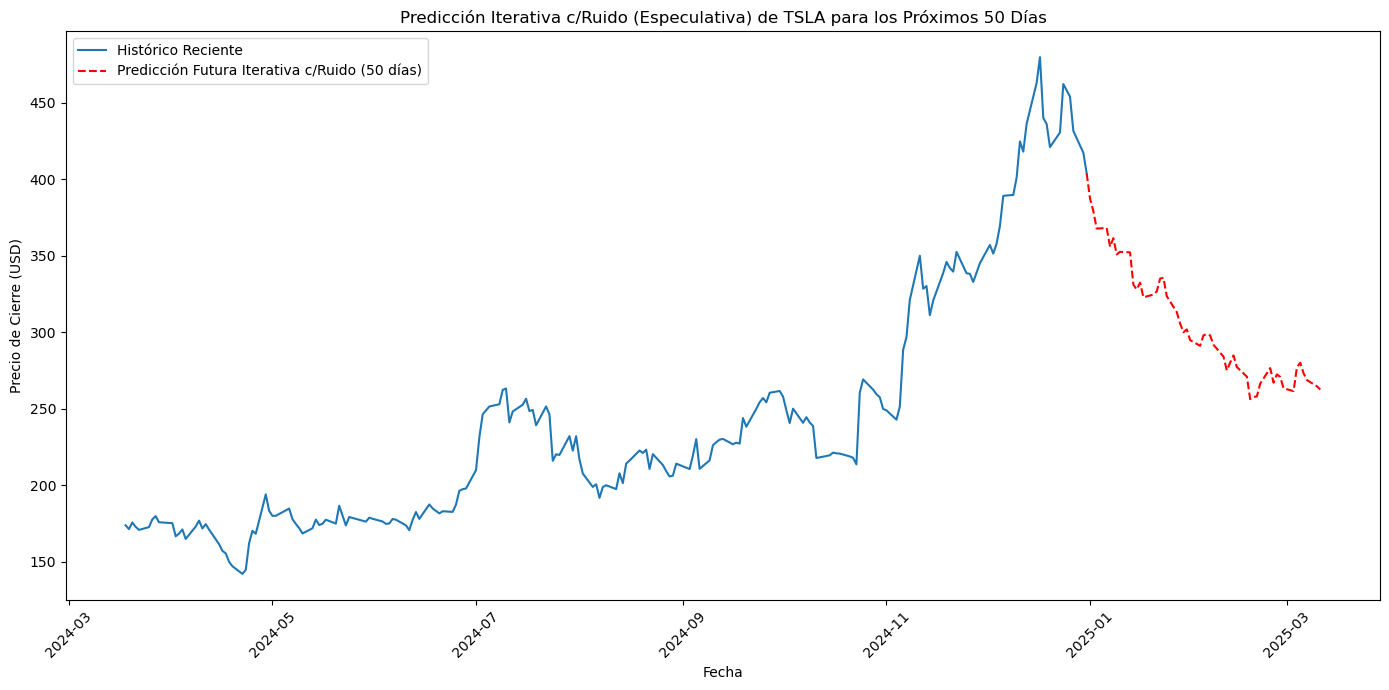


--- Predicciones Iterativas c/Ruido (Especulativas) para los próximos 50 días hábiles ---
       Fecha  Predicción
0 2025-01-01  387.437164
1 2025-01-02  379.187134
2 2025-01-03  367.797363
3 2025-01-06  368.202332
4 2025-01-07  355.965698
5 2025-01-08  361.518799
6 2025-01-09  350.901215
7 2025-01-10  352.592102
8 2025-01-13  352.237396
9 2025-01-14  331.011383


In [11]:
# Predicción Futura Iterativa con Ruido Añadido ---

# --- Parámetros de Predicción ---
n_future_steps = 50
current_window_size_pred = window_size # Usar el window_size del modelo

noise_level = 0.02 

# --- Preparar la Última Secuencia Conocida DIRECTAMENTE de 'data' ---
last_actual_sequence_np = data[target_column].iloc[-current_window_size_pred:].values
last_actual_sequence_reshaped = last_actual_sequence_np.reshape(-1, 1)
last_sequence_np_scaled = scaler.transform(last_actual_sequence_reshaped)
last_sequence_pred = torch.tensor(last_sequence_np_scaled, dtype=torch.float32).unsqueeze(0).to(device)
current_sequence_pred = last_sequence_pred

# --- Bucle de Predicción Iterativa con Ruido ---
model.eval()
future_predictions_scaled = []

print(f"Iniciando predicción iterativa para {n_future_steps} pasos con noise_level={noise_level}...")
with torch.no_grad():
    for i in range(n_future_steps):
        # 1. Predecir el SIGUIENTE paso
        next_pred_scaled = model(current_sequence_pred) # Salida shape: [1, 1]

        # 2. Añadir Ruido Aleatorio (Gaussiano con media 0)
        noise = torch.randn_like(next_pred_scaled) * noise_level # Genera ruido con la misma forma y dispositivo
        next_pred_noisy = next_pred_scaled + noise

        # 3. Asegurarse que la predicción escalada con ruido se mantiene en [0, 1]
        next_pred_noisy = torch.clamp(next_pred_noisy, 0.0, 1.0)

        # 4. Guardar la predicción CON RUIDO (escalada)
        future_predictions_scaled.append(next_pred_noisy.cpu().numpy()[0, 0])

        # 5. Actualizar la secuencia de entrada con la PREDICCIÓN RUIDOSA
        next_pred_tensor = next_pred_noisy.unsqueeze(1) # Shape [1, 1, 1]
        current_sequence_pred = torch.cat((current_sequence_pred[:, 1:, :], next_pred_tensor), dim=1)

print("Predicción iterativa con ruido completada.")

# --- Desescalar las Predicciones (que ahora incluyen ruido) ---
future_predictions_scaled_np = np.array(future_predictions_scaled).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions_scaled_np)

# --- Insertar el último valor real al inicio para continuidad en la gráfica ---
last_real_value = data[target_column].iloc[-1]
future_predictions_continuous = np.insert(future_predictions.flatten(), 0, last_real_value)

# --- Generar Fechas Futuras ---
last_date = data.index[-1]
future_dates_continuous = pd.date_range(start=last_date, periods=n_future_steps + 1, freq='B')

# --- Visualización ---
plt.figure(figsize=(14, 7))
plt.plot(data.index[-200:], data['Close'][-200:], label='Histórico Reciente')
plt.plot(future_dates_continuous, future_predictions_continuous, label=f'Predicción Futura Iterativa c/Ruido ({n_future_steps} días)', color='red', linestyle='--')
plt.title(f'Predicción Iterativa c/Ruido (Especulativa) de {ticker} para los Próximos {n_future_steps} Días')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Mostrar predicciones ---
print(f"\n--- Predicciones Iterativas c/Ruido (Especulativas) para los próximos {n_future_steps} días hábiles ---")
predictions_df = pd.DataFrame({'Fecha': future_dates_continuous[1:], 'Predicción': future_predictions.flatten()})
print(predictions_df.head(10))

--- Iniciando Búsqueda Aleatoria de Hiperparámetros (10 pruebas) ---

--- Prueba 1/10 ---
Parámetros: {'window_size': 60, 'lstm_units': 64, 'num_lstm_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 100, 'patience': 10}


c:\Users\jacob\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  Epoch [20/100], Train Loss: 0.007832, Val Loss: 0.001951
  Epoch [40/100], Train Loss: 0.003712, Val Loss: 0.001404
  Epoch [60/100], Train Loss: 0.003255, Val Loss: 0.001175
  Epoch [80/100], Train Loss: 0.003137, Val Loss: 0.000875
  Epoch [100/100], Train Loss: 0.002644, Val Loss: 0.000828
  Restaurando el mejor modelo para evaluación en Test.
  Resultados Prueba -> MSE: 391.5468, RMSE: 19.7875, MAE: 13.2872


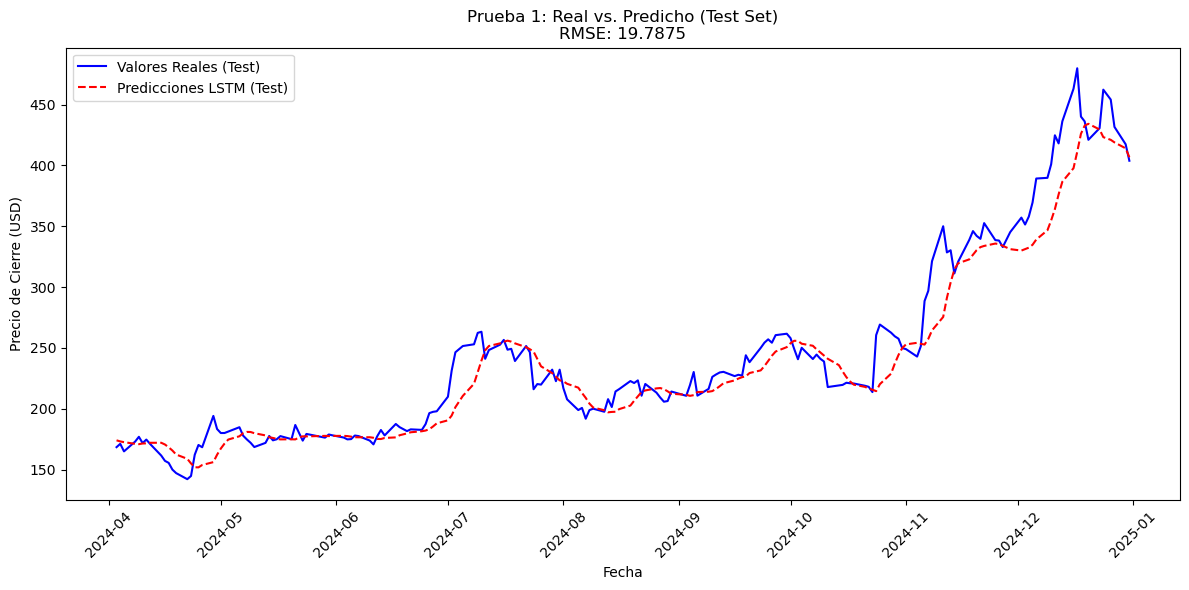


--- Prueba 2/10 ---
Parámetros: {'window_size': 20, 'lstm_units': 128, 'num_lstm_layers': 2, 'dropout_rate': 0.0, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 100, 'patience': 10}
  Epoch [20/100], Train Loss: 0.002810, Val Loss: 0.001990
  Epoch [40/100], Train Loss: 0.001621, Val Loss: 0.001062
  Epoch [60/100], Train Loss: 0.001226, Val Loss: 0.000716
  Epoch [80/100], Train Loss: 0.001080, Val Loss: 0.000606
  Epoch [100/100], Train Loss: 0.000907, Val Loss: 0.000741
  Restaurando el mejor modelo para evaluación en Test.
  Resultados Prueba -> MSE: 249.9322, RMSE: 15.8092, MAE: 11.1041


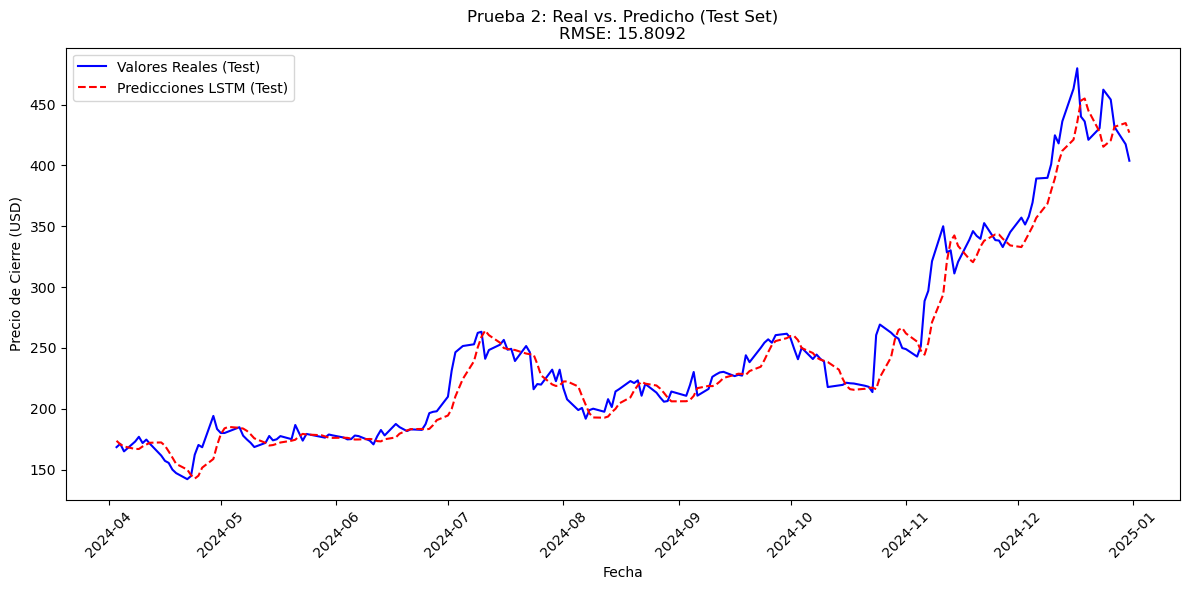


--- Prueba 3/10 ---
Parámetros: {'window_size': 20, 'lstm_units': 128, 'num_lstm_layers': 3, 'dropout_rate': 0.1, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 100, 'patience': 10}
  Epoch [20/100], Train Loss: 0.003120, Val Loss: 0.001785
  Epoch [40/100], Train Loss: 0.002068, Val Loss: 0.000884
  Epoch [60/100], Train Loss: 0.001743, Val Loss: 0.000915
  Epoch [80/100], Train Loss: 0.001529, Val Loss: 0.001141
  Epoch [100/100], Train Loss: 0.001537, Val Loss: 0.000605
  Restaurando el mejor modelo para evaluación en Test.
  Resultados Prueba -> MSE: 279.8149, RMSE: 16.7277, MAE: 11.5321


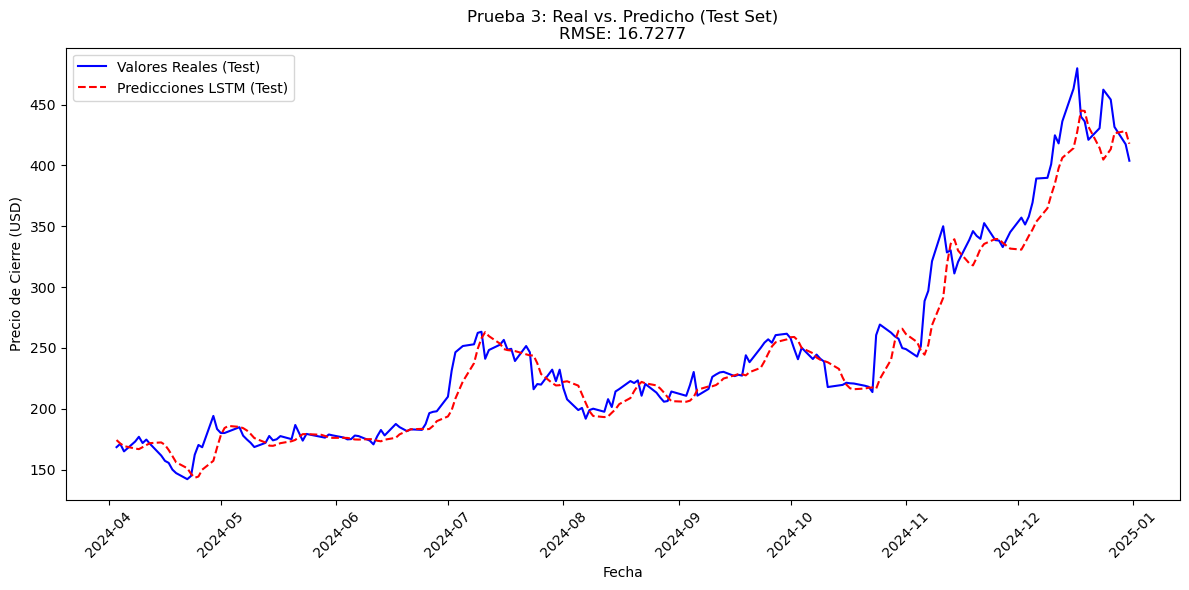


--- Prueba 4/10 ---
Parámetros: {'window_size': 20, 'lstm_units': 16, 'num_lstm_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.005, 'batch_size': 32, 'epochs': 100, 'patience': 10}


c:\Users\jacob\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  Epoch [20/100], Train Loss: 0.003100, Val Loss: 0.002273
  Epoch [40/100], Train Loss: 0.001726, Val Loss: 0.000607
  Epoch [60/100], Train Loss: 0.001597, Val Loss: 0.000672
  Epoch [80/100], Train Loss: 0.001679, Val Loss: 0.000434
  Epoch [100/100], Train Loss: 0.001405, Val Loss: 0.000574
  Restaurando el mejor modelo para evaluación en Test.
  Resultados Prueba -> MSE: 137.4429, RMSE: 11.7236, MAE: 7.9403


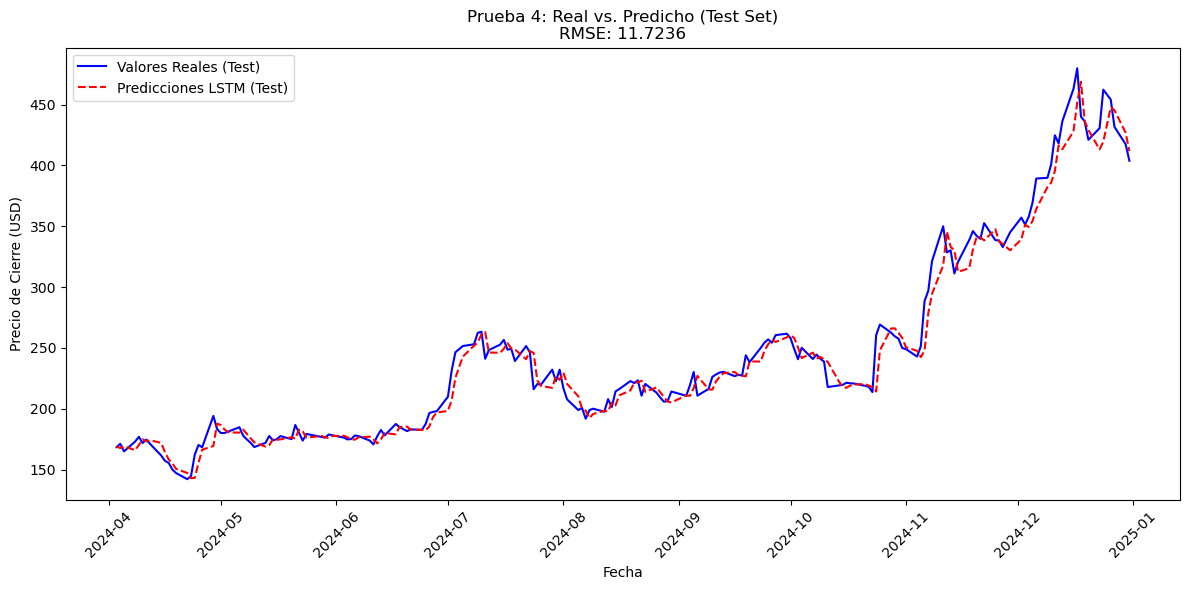


--- Prueba 5/10 ---
Parámetros: {'window_size': 40, 'lstm_units': 100, 'num_lstm_layers': 3, 'dropout_rate': 0.1, 'learning_rate': 0.005, 'batch_size': 32, 'epochs': 100, 'patience': 10}
  Epoch [20/100], Train Loss: 0.001468, Val Loss: 0.000502
  Epoch [40/100], Train Loss: 0.000936, Val Loss: 0.000420
  Early stopping activado después de 44 epochs.
  Restaurando el mejor modelo para evaluación en Test.
  Resultados Prueba -> MSE: 149.1708, RMSE: 12.2136, MAE: 8.1243


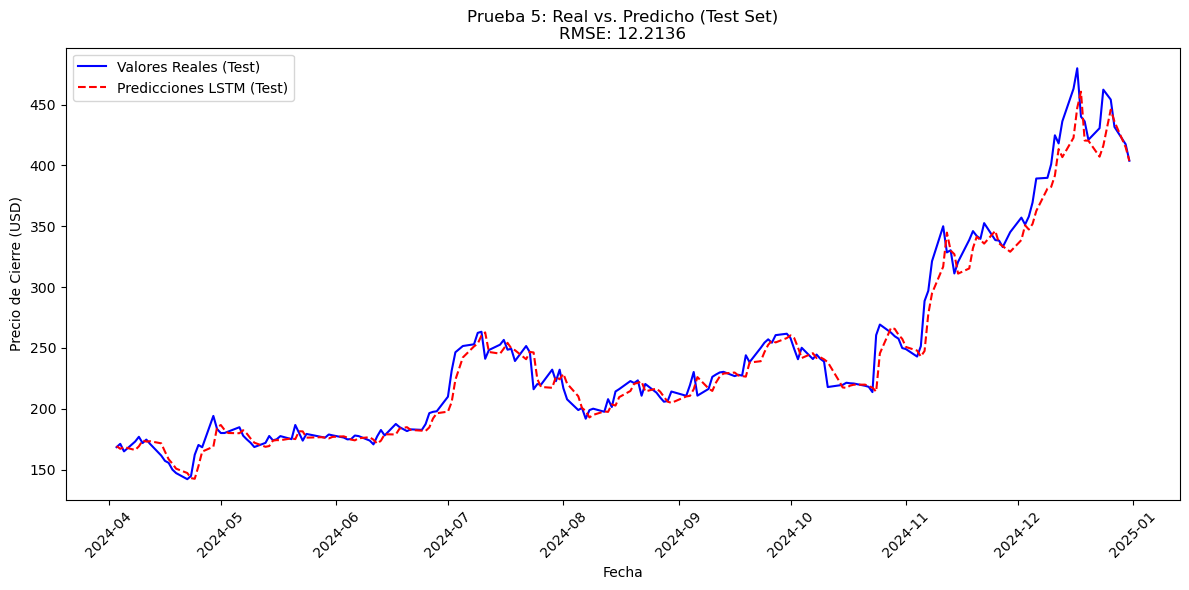


--- Prueba 6/10 ---
Parámetros: {'window_size': 40, 'lstm_units': 64, 'num_lstm_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.005, 'batch_size': 16, 'epochs': 100, 'patience': 10}


c:\Users\jacob\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  Epoch [20/100], Train Loss: 0.001460, Val Loss: 0.000869
  Epoch [40/100], Train Loss: 0.001057, Val Loss: 0.000464
  Epoch [60/100], Train Loss: 0.000925, Val Loss: 0.000386
  Early stopping activado después de 66 epochs.
  Restaurando el mejor modelo para evaluación en Test.
  Resultados Prueba -> MSE: 130.4639, RMSE: 11.4221, MAE: 7.8530


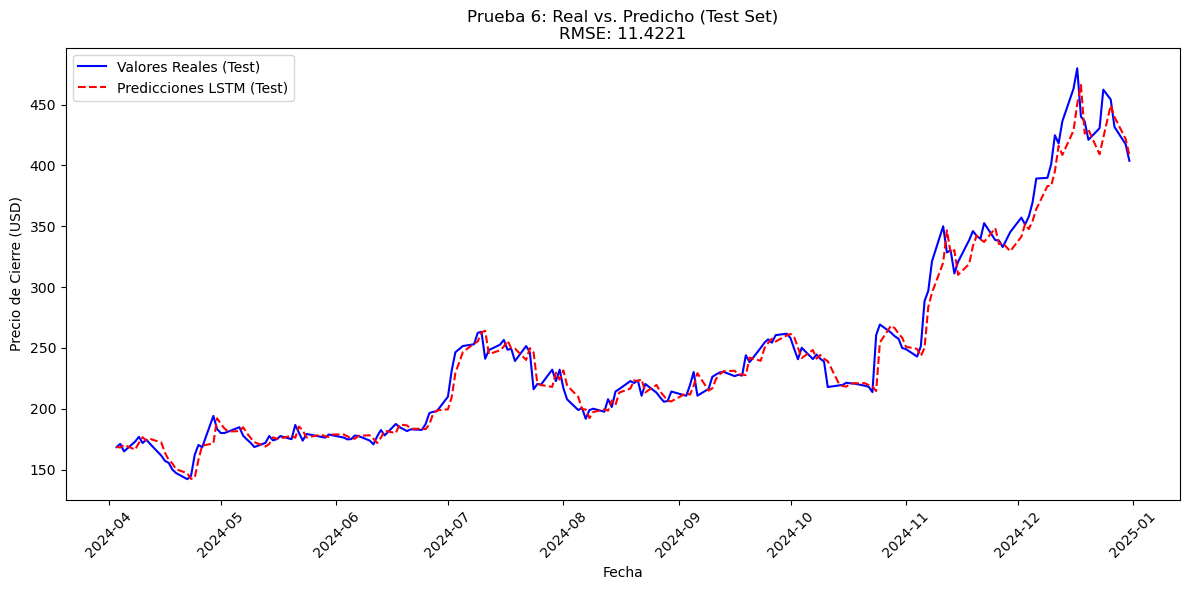


--- Prueba 7/10 ---
Parámetros: {'window_size': 40, 'lstm_units': 160, 'num_lstm_layers': 2, 'dropout_rate': 0.0, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 100, 'patience': 10}
  Epoch [20/100], Train Loss: 0.005572, Val Loss: 0.001885
  Epoch [40/100], Train Loss: 0.002674, Val Loss: 0.001749
  Epoch [60/100], Train Loss: 0.002078, Val Loss: 0.001434
  Epoch [80/100], Train Loss: 0.001837, Val Loss: 0.001252
  Epoch [100/100], Train Loss: 0.001754, Val Loss: 0.001023
  Restaurando el mejor modelo para evaluación en Test.
  Resultados Prueba -> MSE: 445.7015, RMSE: 21.1116, MAE: 14.3417


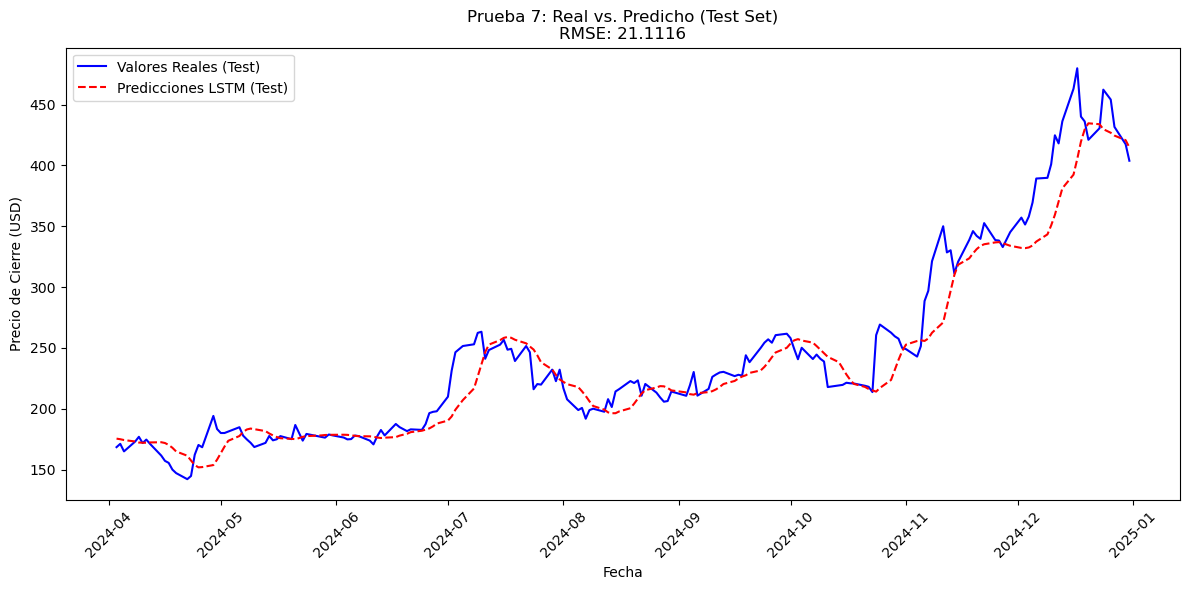


--- Prueba 8/10 ---
Parámetros: {'window_size': 20, 'lstm_units': 16, 'num_lstm_layers': 2, 'dropout_rate': 0.0, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 100, 'patience': 10}
  Epoch [20/100], Train Loss: 0.004312, Val Loss: 0.002793
  Early stopping activado después de 26 epochs.
  Restaurando el mejor modelo para evaluación en Test.
  Resultados Prueba -> MSE: 1422.6885, RMSE: 37.7185, MAE: 25.7247


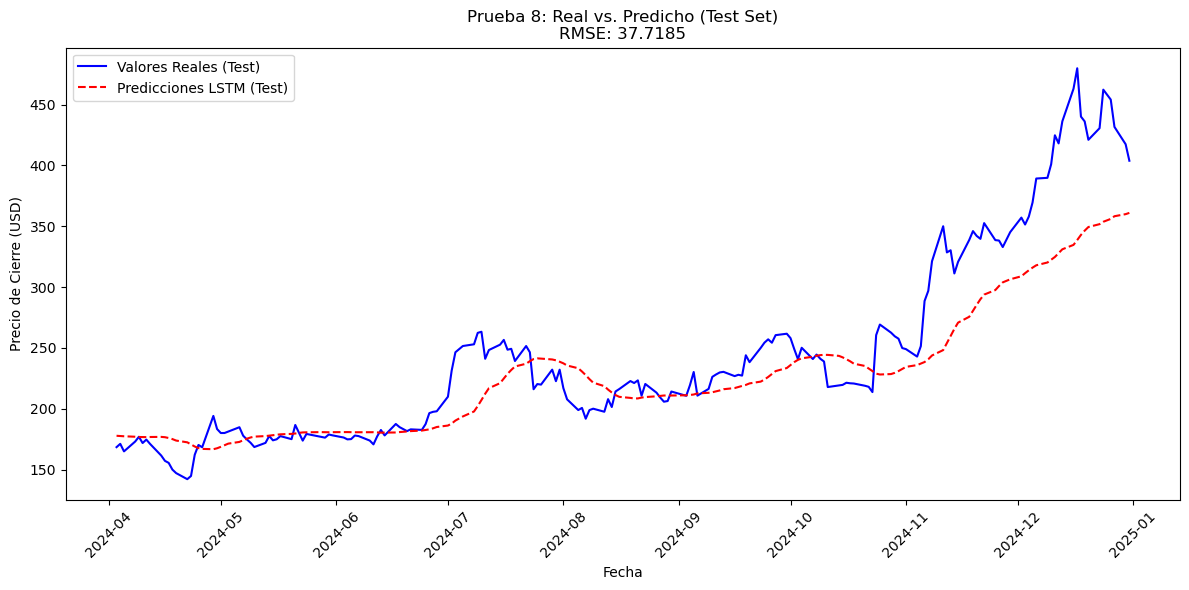


--- Prueba 9/10 ---
Parámetros: {'window_size': 40, 'lstm_units': 160, 'num_lstm_layers': 2, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'patience': 10}
  Epoch [20/100], Train Loss: 0.001509, Val Loss: 0.001157
  Epoch [40/100], Train Loss: 0.001136, Val Loss: 0.000520
  Epoch [60/100], Train Loss: 0.001119, Val Loss: 0.000427
  Epoch [80/100], Train Loss: 0.000899, Val Loss: 0.000424
  Epoch [100/100], Train Loss: 0.000818, Val Loss: 0.000885
  Restaurando el mejor modelo para evaluación en Test.
  Resultados Prueba -> MSE: 128.9047, RMSE: 11.3536, MAE: 7.7468


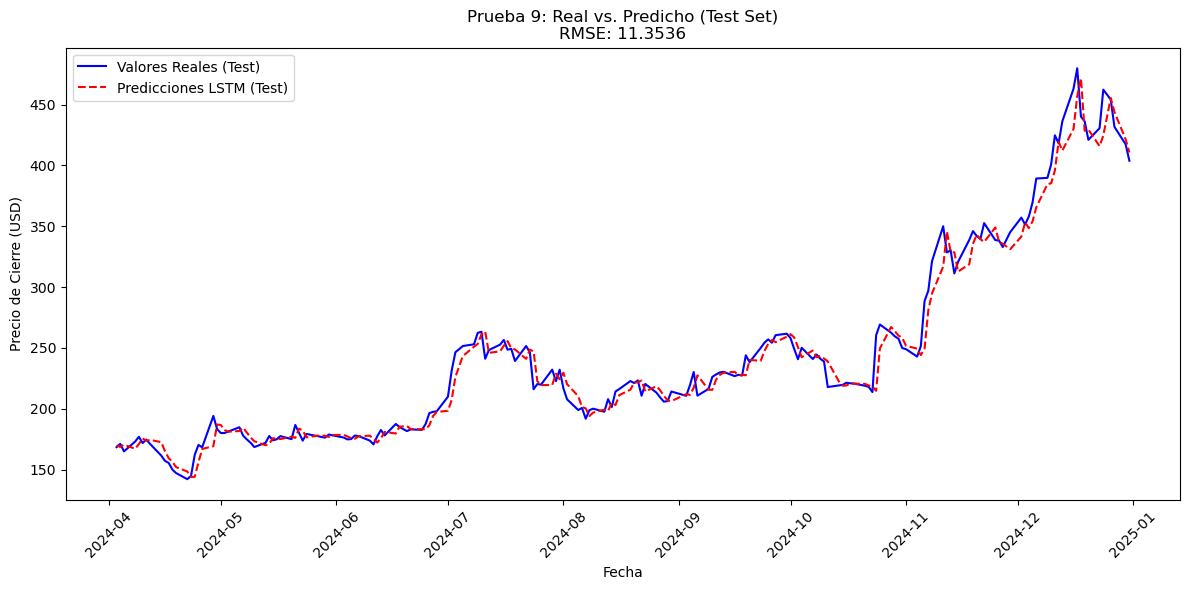


--- Prueba 10/10 ---
Parámetros: {'window_size': 40, 'lstm_units': 100, 'num_lstm_layers': 2, 'dropout_rate': 0.0, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'patience': 10}
  Epoch [20/100], Train Loss: 0.000885, Val Loss: 0.001131
  Epoch [40/100], Train Loss: 0.000673, Val Loss: 0.000387
  Epoch [60/100], Train Loss: 0.000606, Val Loss: 0.001013
  Early stopping activado después de 73 epochs.
  Restaurando el mejor modelo para evaluación en Test.
  Resultados Prueba -> MSE: 130.0107, RMSE: 11.4022, MAE: 7.6876


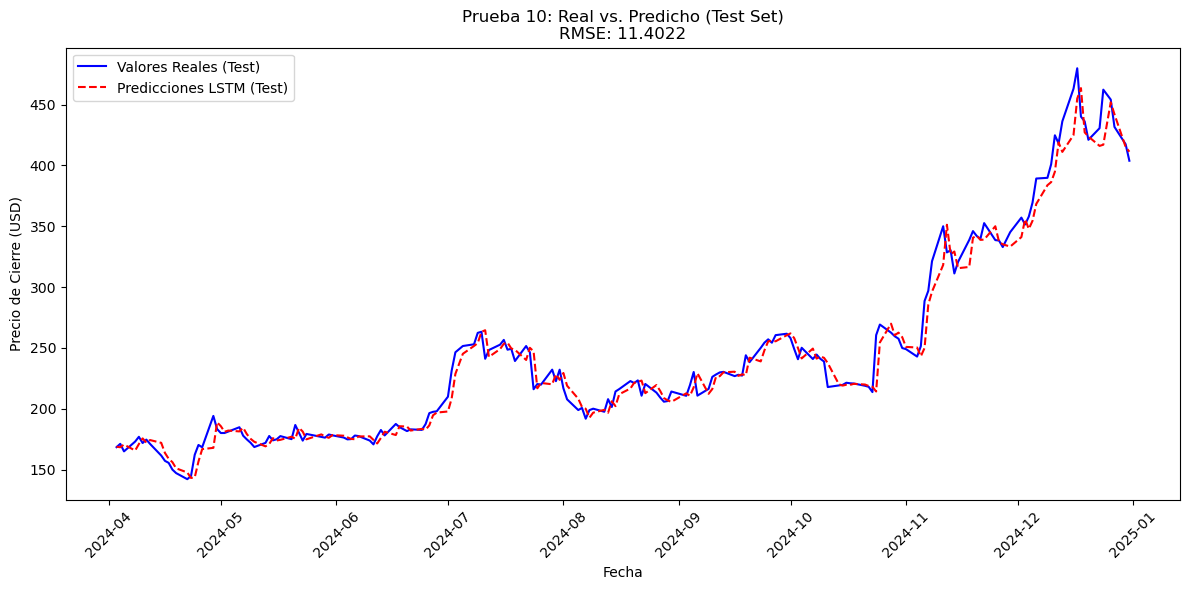


--- Búsqueda Aleatoria Completada ---

--- Mejores 5 Resultados (ordenados por RMSE en Test) ---

Ranking 1:
  RMSE (Test): 11.3536
  MAE (Test): 7.7468
  MSE (Test): 128.9047
  Mejor Loss Validación: 0.000339
  Épocas Ejecutadas: 100
  Tiempo: 27.32s
  Parámetros: {'window_size': 40, 'lstm_units': 160, 'num_lstm_layers': 2, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'patience': 10}

Ranking 2:
  RMSE (Test): 11.4022
  MAE (Test): 7.6876
  MSE (Test): 130.0107
  Mejor Loss Validación: 0.000315
  Épocas Ejecutadas: 73
  Tiempo: 4.24s
  Parámetros: {'window_size': 40, 'lstm_units': 100, 'num_lstm_layers': 2, 'dropout_rate': 0.0, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'patience': 10}

Ranking 3:
  RMSE (Test): 11.4221
  MAE (Test): 7.8530
  MSE (Test): 130.4639
  Mejor Loss Validación: 0.000334
  Épocas Ejecutadas: 66
  Tiempo: 14.81s
  Parámetros: {'window_size': 40, 'lstm_units': 64, 'num_lstm_layers': 1, 'dropout_rate': 0.2, 'learnin

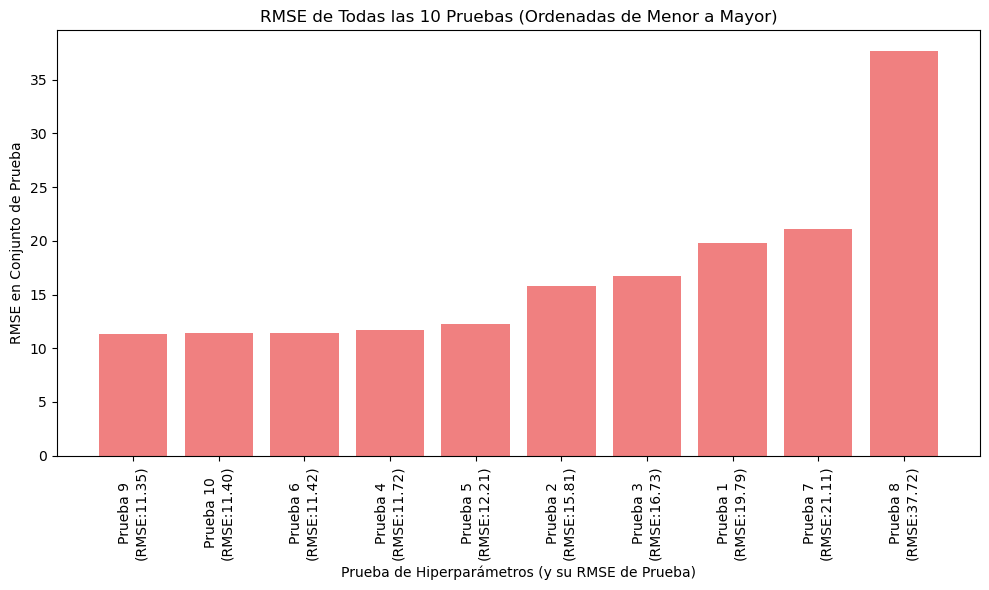

In [12]:
# --- Búsqueda Automatizada  ---
import random
import time
import copy
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# --- Espacio de Búsqueda de Hiperparámetros ---
param_space = {
    'window_size': [20, 40, 60],
    'lstm_units': [16, 32, 64, 100, 128, 160],
    'num_lstm_layers': [1, 2, 3],
    'dropout_rate': [0.0, 0.1, 0.2],
    'learning_rate': [0.01, 0.005, 0.001, 0.0005, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [100],
    'patience': [10, 15]
}
num_trials = 10

all_results = []

original_price_data_search = data[[target_column]].copy()

print(f"--- Iniciando Búsqueda Aleatoria de Hiperparámetros ({num_trials} pruebas) ---")

for trial in range(num_trials):
    print(f"\n--- Prueba {trial + 1}/{num_trials} ---")
    start_trial_time = time.time()

    # --- 1. Seleccionar Hiperparámetros ---
    params = {k: random.choice(v) for k, v in param_space.items()}
    print(f"Parámetros: {params}")

    # --- 2. Preparar Datos (Train/Val/Test) para esta prueba ---
    current_window_size_s = params['window_size']
    data_len_search = len(original_price_data_search)
    train_split_idx_s = int(data_len_search * 0.70)
    val_split_idx_s = int(data_len_search * 0.85)

    train_data_s = original_price_data_search[:train_split_idx_s]
    val_data_s = original_price_data_search[train_split_idx_s:val_split_idx_s]
    test_data_s = original_price_data_search[val_split_idx_s:]

    scaler_trial = MinMaxScaler(feature_range=(0, 1))
    scaler_trial.fit(train_data_s)
    scaled_train_data_np_s = scaler_trial.transform(train_data_s)
    scaled_val_data_np_s = scaler_trial.transform(val_data_s)
    scaled_test_data_np_s = scaler_trial.transform(test_data_s)

    # Crear secuencias
    X_train_np_s, y_train_np_s = create_sequences(scaled_train_data_np_s, current_window_size_s)
    X_val_np_s, y_val_np_s = create_sequences(np.concatenate((scaled_train_data_np_s[-current_window_size_s:], scaled_val_data_np_s)), current_window_size_s)
    X_test_np_s, y_test_np_s = create_sequences(np.concatenate((scaled_val_data_np_s[-current_window_size_s:], scaled_test_data_np_s)), current_window_size_s)

    # Convertir a Tensores
    X_train_s = torch.tensor(X_train_np_s, dtype=torch.float32).unsqueeze(-1)
    y_train_s = torch.tensor(y_train_np_s, dtype=torch.float32).unsqueeze(-1)
    X_val_s = torch.tensor(X_val_np_s, dtype=torch.float32).unsqueeze(-1)
    y_val_s = torch.tensor(y_val_np_s, dtype=torch.float32).unsqueeze(-1)
    X_test_s = torch.tensor(X_test_np_s, dtype=torch.float32).unsqueeze(-1)
    y_test_s = torch.tensor(y_test_np_s, dtype=torch.float32).unsqueeze(-1)

    # --- Fechas para el CONJUNTO DE PRUEBA de esta división ---
    test_start_idx_s = val_split_idx_s # Índice original donde empiezan los datos de prueba
    test_dates_s = original_price_data_search.index[test_start_idx_s:] # Seleccionar todas las fechas desde el inicio de la prueba

    # Ajustar longitud final
    test_dates_s = test_dates_s[:len(y_test_s)]

    # --- 3. Crear DataLoaders ---
    current_batch_size_s = params['batch_size']
    train_dataset_s = TimeSeriesDataset(X_train_s, y_train_s)
    val_dataset_s = TimeSeriesDataset(X_val_s, y_val_s)
    test_dataset_s = TimeSeriesDataset(X_test_s, y_test_s)
    train_loader_s = DataLoader(train_dataset_s, batch_size=current_batch_size_s, shuffle=True)
    val_loader_s = DataLoader(val_dataset_s, batch_size=current_batch_size_s, shuffle=False)
    test_loader_s = DataLoader(test_dataset_s, batch_size=current_batch_size_s, shuffle=False)

    # --- 4. Definir Modelo, Pérdida y Optimizador ---
    model_trial = LSTMModel(input_size=1, hidden_layer_size=params['lstm_units'], num_layers=params['num_lstm_layers'], output_size=1, dropout_prob=params['dropout_rate']).to(device)
    criterion_trial = nn.MSELoss()
    optimizer_trial = optim.Adam(model_trial.parameters(), lr=params['learning_rate'])

    # --- 5. Bucle de Entrenamiento ---
    best_val_loss_trial = float('inf')
    epochs_no_improve_trial = 0
    best_model_state_trial = None
    epochs_run_trial = 0

    for epoch in range(params['epochs']):
        model_trial.train()
        running_loss_trial = 0.0
        batch_count_trial = 0
        for inputs, targets in train_loader_s:
             inputs, targets = inputs.to(device), targets.to(device)
             optimizer_trial.zero_grad()
             outputs = model_trial(inputs)
             loss = criterion_trial(outputs, targets)
             loss.backward()
             optimizer_trial.step()
             running_loss_trial += loss.item()
             batch_count_trial += 1
        avg_train_loss_trial = running_loss_trial / batch_count_trial if batch_count_trial > 0 else 0

        # Validación
        model_trial.eval()
        running_val_loss_trial = 0.0
        val_batch_count_trial = 0
        with torch.no_grad():
            for inputs, targets in val_loader_s:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model_trial(inputs)
                loss = criterion_trial(outputs, targets)
                running_val_loss_trial += loss.item()
                val_batch_count_trial += 1
        avg_val_loss_trial = running_val_loss_trial / val_batch_count_trial if val_batch_count_trial > 0 else float('inf')

        epochs_run_trial = epoch + 1
        if (epoch + 1) % 20 == 0 or epoch == params['epochs'] - 1:
             print(f'  Epoch [{epoch+1}/{params["epochs"]}], Train Loss: {avg_train_loss_trial:.6f}, Val Loss: {avg_val_loss_trial:.6f}')

        # Early Stopping Check
        if avg_val_loss_trial < best_val_loss_trial:
            best_val_loss_trial = avg_val_loss_trial
            epochs_no_improve_trial = 0
            best_model_state_trial = copy.deepcopy(model_trial.state_dict())
        else:
            epochs_no_improve_trial += 1
        if epochs_no_improve_trial >= params['patience']:
            print(f'  Early stopping activado después de {epoch+1} epochs.')
            break

    # --- 6. Cargar el Mejor Modelo y Evaluar en Test Set ---
    model_trial.load_state_dict(best_model_state_trial if best_model_state_trial else model_trial.state_dict())
    print("  Restaurando el mejor modelo para evaluación en Test.")

    model_trial.eval()
    all_preds_test = []
    all_targets_test = []
    with torch.no_grad():
        for inputs, targets in test_loader_s:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_trial(inputs)
            all_preds_test.append(outputs.cpu().numpy())
            all_targets_test.append(targets.cpu().numpy())

    # Verificar antes de concatenar
    if not all_preds_test or not all_targets_test:
        print(f"  Skipping evaluation for Trial {trial + 1}: No predictions/targets generated for test set.")
        continue # Saltar al siguiente trial

    predicted_scaled_np_test = np.concatenate(all_preds_test, axis=0)
    actual_scaled_np_test = np.concatenate(all_targets_test, axis=0)

    # Desescalar usando el scaler de ESTA prueba (scaler_trial)
    predicted_prices_test = scaler_trial.inverse_transform(predicted_scaled_np_test)
    actual_prices_test = scaler_trial.inverse_transform(actual_scaled_np_test)

    # Calcular Métricas de Prueba
    mse_test = mean_squared_error(actual_prices_test, predicted_prices_test)
    rmse_test = math.sqrt(mse_test)
    mae_test = mean_absolute_error(actual_prices_test, predicted_prices_test)

    print(f"  Resultados Prueba -> MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")

    # --- 7. GUARDAR RESULTADOS ---
    trial_result = {
        'trial': trial + 1, 'params': params, 'best_val_loss': best_val_loss_trial,
        'epochs_run': epochs_run_trial, 'test_mse': mse_test, 'test_rmse': rmse_test,
        'test_mae': mae_test, 'time_sec': time.time() - start_trial_time
    }
    all_results.append(trial_result)

    # --- 8. GRÁFICA DE COMPARACIÓN PARA ESTA PRUEBA (EN TEST SET) ---
    if len(test_dates_s) == len(actual_prices_test): # Comprobación de longitud antes de graficar
        plt.figure(figsize=(12, 6))
        plt.plot(test_dates_s, actual_prices_test.flatten(), label='Valores Reales (Test)', color='blue', linestyle='-')
        plt.plot(test_dates_s, predicted_prices_test.flatten(), label='Predicciones LSTM (Test)', color='red', linestyle='--')
        plt.title(f'Prueba {trial + 1}: Real vs. Predicho (Test Set)\nRMSE: {rmse_test:.4f}')
        plt.xlabel('Fecha')
        plt.ylabel('Precio de Cierre (USD)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"  Advertencia: No se pudo generar gráfica de prueba para Trial {trial + 1} (longitudes no coinciden: {len(test_dates_s)} vs {len(actual_prices_test)}).")


print(f"\n--- Búsqueda Aleatoria Completada ---")

# --- 9. Encontrar y Mostrar los Mejores Resultados ---
if all_results: # Asegurarse que hubo resultados
    best_results = sorted(all_results, key=lambda x: x['test_rmse']) # Ordenar por RMSE de prueba

    print("\n--- Mejores 5 Resultados (ordenados por RMSE en Test) ---")
    for i, res in enumerate(best_results[:5]):
        print(f"\nRanking {i+1}:")
        print(f"  RMSE (Test): {res['test_rmse']:.4f}")
        print(f"  MAE (Test): {res['test_mae']:.4f}")
        print(f"  MSE (Test): {res['test_mse']:.4f}")
        print(f"  Mejor Loss Validación: {res['best_val_loss']:.6f}")
        print(f"  Épocas Ejecutadas: {res['epochs_run']}")
        print(f"  Tiempo: {res['time_sec']:.2f}s")
        print(f"  Parámetros: {res['params']}")

    best_overall = best_results[0]
    print("\n--- Mejor Configuración Encontrada (según Test RMSE) ---")
    print(f"RMSE (Test): {best_overall['test_rmse']:.4f}")
    print(f"MAE (Test): {best_overall['test_mae']:.4f}")
    print(f"Parámetros: {best_overall['params']}")

    # --- 10. GRÁFICA RESUMEN DE RMSE DE TODAS LAS PRUEBAS ORDENADAS ---
    all_sorted_results = best_results
    num_total_trials = len(all_sorted_results)
    trial_labels = [f"Prueba {res['trial']}\n(RMSE:{res['test_rmse']:.2f})" for res in all_sorted_results]
    rmse_values = [res['test_rmse'] for res in all_sorted_results]

    plt.figure(figsize=(max(10, num_total_trials * 0.5), 6))
    plt.bar(range(num_total_trials), rmse_values, color='lightcoral')
    plt.xlabel('Prueba de Hiperparámetros (y su RMSE de Prueba)')
    plt.ylabel('RMSE en Conjunto de Prueba')
    plt.title(f'RMSE de Todas las {num_total_trials} Pruebas (Ordenadas de Menor a Mayor)')
    plt.xticks(range(num_total_trials), trial_labels, rotation=90, ha='center')
    plt.tight_layout()
    plt.show()

else:
    print("No se completó ninguna prueba.")